# Automatic registration of RGB images

%pip install -U git+https://github.com/fligt/maxrf4u.git

In [1]:
import maxrf4u as mx 
import zarr 
import dask 
import numpy as np
import os 
from glob import glob
import re
import matplotlib.pyplot as plt 
import dask.array as da 
import cv2

In [2]:
os.chdir('..') 
print(f'maxrf4u: {mx.__version__}, zarr: {zarr.__version__}, dask: {dask.__version__}')

maxrf4u: 0.1.41, zarr: 3.0.4, dask: 2024.11.2


In [3]:
!tree --filelimit 10

.
├── 14. Notebooks and data Koen en Frank
├── data
│   ├── interim
│   │   ├── 02. JPEG Res.zip
│   │   ├── maxrf
│   │   │   ├── datastacks  [16 entries exceeds filelimit, not opening dir]
│   │   │   ├── element-maps
│   │   │   ├── previews  [16 entries exceeds filelimit, not opening dir]
│   │   │   └── rgb_imreg
│   │   ├── rgb_jpegs-from-tifs  [35 entries exceeds filelimit, not opening dir]
│   │   └── Weimar-PhaseOne-rot270  [72 entries exceeds filelimit, not opening dir]
│   └── raw
│       ├── 03. MSI Phase One.zip
│       ├── filetree.txt
│       └── Weimar-folders
│           ├── Weimar_Keyence
│           │   ├── 18  [86 entries exceeds filelimit, not opening dir]
│           │   ├── 3  [26 entries exceeds filelimit, not opening dir]
│           │   ├── 35  [38 entries exceeds filelimit, not opening dir]
│           │   ├── 8  [25 entries exceeds filelimit, not opening dir]
│           │   ├── christmas  [26 entries exceeds filelimit, not opening dir]
│           │   └── Z

## Renaming jpgs with padded page numbers (done)

In [37]:
old_jpg_files = glob('./data/interim/**/*.jpg')
list(enumerate(old_jpg_files))

[(0, './data/interim/rgb_jpegs-from-tifs/WM-71803-1.jpg'),
 (1, './data/interim/rgb_jpegs-from-tifs/WM-71803-10.jpg'),
 (2, './data/interim/rgb_jpegs-from-tifs/WM-71803-11.jpg'),
 (3, './data/interim/rgb_jpegs-from-tifs/WM-71803-12.jpg'),
 (4, './data/interim/rgb_jpegs-from-tifs/WM-71803-13.jpg'),
 (5, './data/interim/rgb_jpegs-from-tifs/WM-71803-14.jpg'),
 (6, './data/interim/rgb_jpegs-from-tifs/WM-71803-15.jpg'),
 (7, './data/interim/rgb_jpegs-from-tifs/WM-71803-16.jpg'),
 (8, './data/interim/rgb_jpegs-from-tifs/WM-71803-17.jpg'),
 (9, './data/interim/rgb_jpegs-from-tifs/WM-71803-18.jpg'),
 (10, './data/interim/rgb_jpegs-from-tifs/WM-71803-19.jpg'),
 (11, './data/interim/rgb_jpegs-from-tifs/WM-71803-2.jpg'),
 (12, './data/interim/rgb_jpegs-from-tifs/WM-71803-20.jpg'),
 (13, './data/interim/rgb_jpegs-from-tifs/WM-71803-21.jpg'),
 (14, './data/interim/rgb_jpegs-from-tifs/WM-71803-22.jpg'),
 (15, './data/interim/rgb_jpegs-from-tifs/WM-71803-23.jpg'),
 (16, './data/interim/rgb_jpegs-from

In [38]:
new_jpg_files = []
for f in old_jpg_files: 
    n = f'{int(re.match('.*71803-(\\d+)', f).groups()[0]):02}'

    jpg = f'./data/interim/rgb_jpegs-from-tifs/WM-71803-{n}.jpg' 
    new_jpg_files.append(jpg)


In [39]:
for old, new in zip(old_jpg_files, new_jpg_files): 
    os.rename(old, new)

## Video image based registration (done)

In our case, we have the luxury of video gray scale images that can be used as destination images for automatic image registration. 

In [4]:
datastack_files = glob('./data/interim/maxrf/datastacks/*.datastack')
for i, df in enumerate(datastack_files): 
    print(i, df)

0 ./data/interim/maxrf/datastacks/WM-71803-01_400_600_50.datastack
1 ./data/interim/maxrf/datastacks/WM-71803-03_250_300_50.datastack
2 ./data/interim/maxrf/datastacks/WM-71803-08_250_300_50.datastack
3 ./data/interim/maxrf/datastacks/WM-71803-10_250_300_50.datastack
4 ./data/interim/maxrf/datastacks/WM-71803-12_250_300_50.datastack
5 ./data/interim/maxrf/datastacks/WM-71803-13_400_600_50.datastack
6 ./data/interim/maxrf/datastacks/WM-71803-17_400_600_50.datastack
7 ./data/interim/maxrf/datastacks/WM-71803-18_400_300_50_det.datastack
8 ./data/interim/maxrf/datastacks/WM-71803-18_400_500_50.datastack
9 ./data/interim/maxrf/datastacks/WM-71803-19_400_600_50.datastack
10 ./data/interim/maxrf/datastacks/WM-71803-23_400_600_50.datastack
11 ./data/interim/maxrf/datastacks/WM-71803-24_400_600_50.datastack
12 ./data/interim/maxrf/datastacks/WM-71803-29_400_500_50.datastack
13 ./data/interim/maxrf/datastacks/WM-71803-30_250_300_50.datastack
14 ./data/interim/maxrf/datastacks/WM-71803-31_400_600

In [5]:
object_nums = [re.sub('.*(WM-71803-\\d\\d).*', r'\1', df) for df in datastack_files]
object_nums

['WM-71803-01',
 'WM-71803-03',
 'WM-71803-08',
 'WM-71803-10',
 'WM-71803-12',
 'WM-71803-13',
 'WM-71803-17',
 'WM-71803-18',
 'WM-71803-18',
 'WM-71803-19',
 'WM-71803-23',
 'WM-71803-24',
 'WM-71803-29',
 'WM-71803-30',
 'WM-71803-31',
 'WM-71803-35']

In [6]:
src_files = [f'./data/interim/rgb_jpegs-from-tifs/{num}.jpg' for num in  object_nums]
src_ims = [plt.imread(f) for f in src_files]
for i, sf in enumerate(src_files): 
    print(i, sf)

0 ./data/interim/rgb_jpegs-from-tifs/WM-71803-01.jpg
1 ./data/interim/rgb_jpegs-from-tifs/WM-71803-03.jpg
2 ./data/interim/rgb_jpegs-from-tifs/WM-71803-08.jpg
3 ./data/interim/rgb_jpegs-from-tifs/WM-71803-10.jpg
4 ./data/interim/rgb_jpegs-from-tifs/WM-71803-12.jpg
5 ./data/interim/rgb_jpegs-from-tifs/WM-71803-13.jpg
6 ./data/interim/rgb_jpegs-from-tifs/WM-71803-17.jpg
7 ./data/interim/rgb_jpegs-from-tifs/WM-71803-18.jpg
8 ./data/interim/rgb_jpegs-from-tifs/WM-71803-18.jpg
9 ./data/interim/rgb_jpegs-from-tifs/WM-71803-19.jpg
10 ./data/interim/rgb_jpegs-from-tifs/WM-71803-23.jpg
11 ./data/interim/rgb_jpegs-from-tifs/WM-71803-24.jpg
12 ./data/interim/rgb_jpegs-from-tifs/WM-71803-29.jpg
13 ./data/interim/rgb_jpegs-from-tifs/WM-71803-30.jpg
14 ./data/interim/rgb_jpegs-from-tifs/WM-71803-31.jpg
15 ./data/interim/rgb_jpegs-from-tifs/WM-71803-35.jpg


In [17]:
dst_files = sorted(glob('data/raw/Weimar-folders/Weimar-XRF/**/*Video**.tif', recursive=True))
dst_ims = [plt.imread(f) for f in dst_files]
for i, dst in enumerate(dst_files):    
    print(i, dst)

0 data/raw/Weimar-folders/Weimar-XRF/71803-01_MA-XRF/71803-01_Video 1.tif
1 data/raw/Weimar-folders/Weimar-XRF/71803-03_MA-XRF/71803-03_Video 1.tif
2 data/raw/Weimar-folders/Weimar-XRF/71803-08_MA-XRF/71803-08_Video 1.tif
3 data/raw/Weimar-folders/Weimar-XRF/71803-10_MA-XRF/71803-10_Video 1.tif
4 data/raw/Weimar-folders/Weimar-XRF/71803-12_MA-XRF/71803-12_Video 1.tif
5 data/raw/Weimar-folders/Weimar-XRF/71803-13_MA-XRF/71803-13_Video 1.tif
6 data/raw/Weimar-folders/Weimar-XRF/71803-17_MA-XRF/71803-17_Video 1.tif
7 data/raw/Weimar-folders/Weimar-XRF/71803-18_MA-XRF/71803-18_MA-XRF_detail-paper-margin/71803-18_det_Video 1.tif
8 data/raw/Weimar-folders/Weimar-XRF/71803-18_MA-XRF/71803-18__Video 1.tif
9 data/raw/Weimar-folders/Weimar-XRF/71803-19_MA-XRF/71803-19_Video 1.tif
10 data/raw/Weimar-folders/Weimar-XRF/71803-23_MA-XRF/71803-23_Video 1.tif
11 data/raw/Weimar-folders/Weimar-XRF/71803-24_MA-XRF/71803-24_Video 1.tif
12 data/raw/Weimar-folders/Weimar-XRF/71803-29_MA-XRF/71803-29___Vide

In [21]:
dst_files

['data/raw/Weimar-folders/Weimar-XRF/71803-01_MA-XRF/71803-01_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-03_MA-XRF/71803-03_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-08_MA-XRF/71803-08_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-10_MA-XRF/71803-10_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-12_MA-XRF/71803-12_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-13_MA-XRF/71803-13_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-17_MA-XRF/71803-17_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-18_MA-XRF/71803-18_MA-XRF_detail-paper-margin/71803-18_det_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-18_MA-XRF/71803-18__Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-19_MA-XRF/71803-19_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-23_MA-XRF/71803-23_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-24_MA-XRF/71803-24_Video 1.tif',
 'data/raw/Weimar-folders/Weimar-XRF/71803-29_M

In [ ]:
i = 0 
for src_im, dst_im, datastack_file in zip(src_ims, dst_ims, datastack_files): 
    print(f'[{i}] Writing imreg data to: {datastack_file}...')
    i = i + 1 
    mx.imreg_to_datastack(src_im, dst_im, datastack_file) 

## Cool!

Here are the registered images! 

In [23]:
%matplotlib widget

In [27]:
imvis_list = []
extent_list = []
for datastack_file in datastack_files: 
    ds = mx.DataStack(datastack_file)
    im = ds.read('imvis_reg')
    extent = ds.read('imvis_extent')
    imvis_list.append(im)
    extent_list.append(extent)

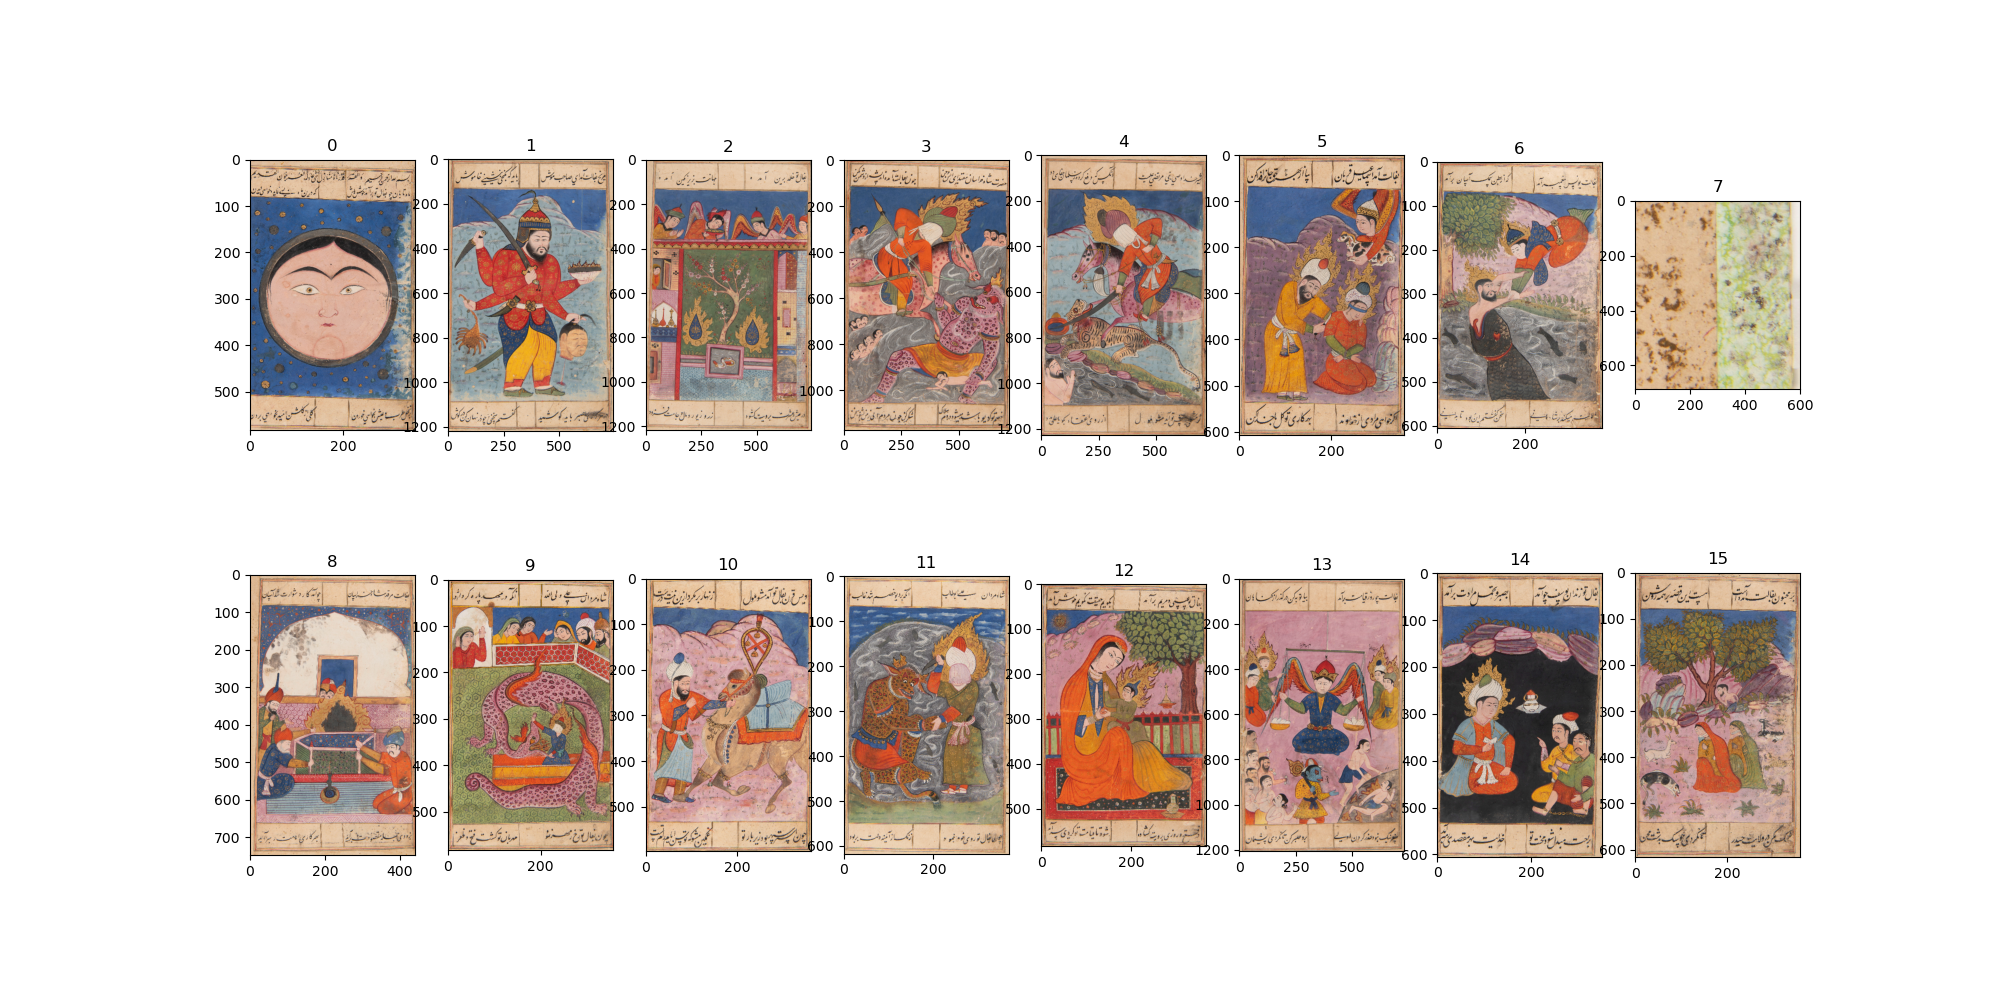

In [28]:
fig, axs = plt.subplots(ncols=8, nrows=2, figsize=[20, 10])
axs = axs.flatten()
for i, [im, ax, extent] in enumerate(zip(imvis_list, axs, extent_list)): 
    ax.imshow(im, extent=extent)
    ax.set_title(i)